
Saliency maps for Convolutional Neural Networks are a technique used to visualize and understand the behavior of CNN models, particularly in tasks such as image classification, object detection and segmentation. They highlight which parts of an input (like an image) are most important for a model's decision. They help with understanding how a model is making its predictions by showing the areas that contributed most to its output. The term "saliency" refers to the prominence of certain features, and in the context of deep learning saliency maps can reveal which pixels in an image most influenced the model's classification task.

In this post, we walkthrough the process of generating saliency maps for holdout images using the CIFAR-10 dataset. To begin, we’ll train a simple Convolutional Neural Network model using PyTorch. After the model is trained, we will use it to generate saliency maps for a random selection of holdout images from the dataset. These saliency maps will help us visualize which parts of the images were most influential in the model's predictions. 

In [1]:

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.transform import rescale, resize

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

np.set_printoptions(suppress=True, precision=8, linewidth=1000)
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Number of images to process in each batch. 
batch_size = 32


# Specify CIFAR-10 classes.
classes = [
    "plane", "car", "bird", "cat", "deer", "dog", 
    "frog", "horse", "ship", "truck"
    ]


# ImageNet transforms to normalize images. 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
     )


# Download CIFAR-10 training and validation data.
train_ds = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
    )
valid_ds = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
    )

# Create training and validation DataLoader instances. This is what gets 
# iterated over during training. 
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

print(f"\nNumber of training batches of size {batch_size}: {len(train_loader)}")


Files already downloaded and verified
Files already downloaded and verified

Number of training batches of size 32: 1563


<br> 

Define network, training and validation loops.


In [2]:

import torch.nn as nn
import torch.nn.functional as F


class BasicCNN(nn.Module):
    def __init__(self, dropout=0):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)
        self.drp = nn.Dropout(p=dropout)
        
    def forward(self, X):
        output = self.pool(F.relu(self.conv1(X)))
        output = self.pool(F.relu(self.conv2(output)))
        output = torch.flatten(output, 1)
        output = F.relu(self.drp(self.fc1(output)))
        output = F.relu(self.drp(self.fc2(output)))
        output = self.fc3(output)
        return output


def epoch_trainer(epoch, data_loader, model, loss_fn, optimizer, device, verbose=True):
    """
    Execute a single training epoch. Return last batch training loss
    and accuracy. 
    """
    loss, checkpoint_loss, correct, samples = 0.0, 0.0, 0, 0

    # Put model in train mode.
    model.train()

    # Iterate over batches in data_loader. 
    for ii, (X, yactual) in enumerate(data_loader):

        # Send datasets to device. 
        X, yactual = X.to(device), yactual.to(device)

        # Zero out parameter gradients.
        optimizer.zero_grad()

        # Get model predictions (forward pass). 
        ypred = model(X)

        # Compute loss. 
        loss_ii = loss_fn(ypred, yactual)

        # Backpropagation and optimizer step. 
        loss_ii.backward()
        optimizer.step()

        # Update running_loss.
        loss+=loss_ii.item()
        correct+=(ypred.argmax(dim=1)==yactual).type(torch.float).sum().item()
        samples+=yactual.size(dim=0)

        # Print running_loss for every 100 mini-batches.
        if ii % 250 == 0:
            checkpoint_acc = correct / samples
            checkpoint_loss = loss / 250

            if verbose:
                print(f"\t+ [train][epoch={epoch}, batch={ii}] loss = {checkpoint_loss:,.5f}, acc = {checkpoint_acc:.5f}.")
            
            loss, correct, samples = 0.0, 0, 0

    return checkpoint_loss, checkpoint_acc
        


def epoch_validator(data_loader, model, loss_fn, optimizer, device):
    """
    Execute a single validation epoch. Return average validation loss
    and accuracy.
    """
    valid_loss, correct = 0.0, 0

    # Put model in validation mode.
    model.eval()

    with torch.no_grad():

        for ii, (X, yactual) in enumerate(data_loader, start=1):

            # Send dataset and target to device. 
            X, yactual = X.to(device), yactual.to(device)

            # Get model predictions. 
            ypred = model(X)

            # Compute loss and update valid_loss.
            valid_loss+=loss_fn(ypred, yactual).item()

            # Count number of correct class predictions.
            correct+=(ypred.argmax(dim=1)==yactual).type(torch.float).sum().item()

    loss, acc = valid_loss / ii, correct / len(data_loader.dataset)

    return loss, acc



<br>

Configure training parameters.

In [3]:

import torch.optim as optim


# Configuration ----------------------------------------------------------------

# Number of epochs.
n_epochs = 25

# Learning rate.
lr = 0.001

# Momentum.
momentum = .90

# Dropout.
dropout = 0.0

# ------------------------------------------------------------------------------

# Check if gpu is available. If not, use cpu. 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize instance of BasicCNN. Put on device for completeness.
mdl = BasicCNN(dropout=dropout).to(device)

# Specify loss function.
loss_fn = nn.CrossEntropyLoss()

# Specify optimizer. 
optimizer = optim.SGD(mdl.parameters(), lr=lr, momentum=momentum)

print(f"device: {device}")



device: cpu


<br>

Train model for 25 epochs.

In [4]:

results = []

for epoch in range(1, n_epochs + 1):

    tloss, tacc = epoch_trainer(
        epoch=epoch, data_loader=train_loader, model=mdl, loss_fn=loss_fn, 
        optimizer=optimizer, device=device, verbose=False
        )
    
    vloss, vacc = epoch_validator(
        data_loader=valid_loader, model=mdl, loss_fn=loss_fn, 
        optimizer=optimizer, device=device
        )
    
    print(f"[epoch={epoch}]: tloss={tloss:.5f}, tacc={tacc:.5f}, vloss={vloss:.5f}, vacc={vacc:.5f}.")

    # Append metrics to results.
    results.append((tloss, tacc, vloss, vacc))



[epoch=1]: tloss=2.11117, tacc=0.23975, vloss=2.01603, vacc=0.27400.
[epoch=2]: tloss=1.71003, tacc=0.36488, vloss=1.68098, vacc=0.37990.
[epoch=3]: tloss=1.54233, tacc=0.44200, vloss=1.53085, vacc=0.44330.
[epoch=4]: tloss=1.43812, tacc=0.48037, vloss=1.42335, vacc=0.47970.
[epoch=5]: tloss=1.37371, tacc=0.50675, vloss=1.34363, vacc=0.51350.
[epoch=6]: tloss=1.31023, tacc=0.53050, vloss=1.30940, vacc=0.53170.
[epoch=7]: tloss=1.25473, tacc=0.55137, vloss=1.26415, vacc=0.54980.
[epoch=8]: tloss=1.19880, tacc=0.58000, vloss=1.20769, vacc=0.57130.
[epoch=9]: tloss=1.14536, tacc=0.60250, vloss=1.23778, vacc=0.56390.
[epoch=10]: tloss=1.10834, tacc=0.60925, vloss=1.15941, vacc=0.58830.
[epoch=11]: tloss=1.10043, tacc=0.61250, vloss=1.12090, vacc=0.60210.
[epoch=12]: tloss=1.06026, tacc=0.62600, vloss=1.11189, vacc=0.60440.
[epoch=13]: tloss=1.04040, tacc=0.63150, vloss=1.10926, vacc=0.60780.
[epoch=14]: tloss=0.98636, tacc=0.65163, vloss=1.08105, vacc=0.62470.
[epoch=15]: tloss=0.99510, ta

<br>


The gradient of the model's output class score (or a specific neuron's activation) with respect to the input image pixels is computed. The gradients are computed using backpropagation through the model. This involves propagating the gradients backward from the output layer to the input layer while computing the partial derivatives of the output with respect to the input. The magnitude of the gradients indicates how sensitive the model's output is to changes in each pixel of the input image. Pixels with higher magnitude gradients are considered more salient and are highlighted in the saliency map. 
Once the gradients are computed, they are typically normalized and then visualized as a saliency map, where brighter regions correspond to more salient parts of the image and darker regions correspond to less salient parts.

Below is a function which computes the saliency map for a give image in CIFAR-10, and returns the map with the original image. This can also be accomplished using libraries such has captum,  but for this demonstration we're keeping it simple:

In [74]:


def get_saliency(tensor, model):
    """
    Return saliency map and original image.
    """
    # Put original image pixels on [0, 1].
    img = tensor.squeeze().permute(1, 2, 0).detach().numpy()

    # img = cv2.resize(img, (224, 224))
    # img = resize(img, (32, 32))
    # img /= np.max(np.abs(img), axis=0)

    model.eval()
    tensor.requires_grad_()
    scores = model(tensor)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0, score_max_index]  

    # Backward method on score_max performs the backward pass in the computation 
    # graph and calculates the gradient of score_max with respect to nodes in the 
    # graph.
    score_max.backward()

    # Saliency would be the gradient with respect to the input image. But note that 
    # the input image has 3 channels, R, G and B. To derive a single class saliency 
    # value for each pixel (i, j),  we take the maximum magnitude across all color 
    # channels.
    saliency, _ = torch.max(tensor.grad.data.abs(), dim=1)

    # Return original image along with saliency map. 
    return img, saliency



def plot_saliency(img, saliency, actual_label, predicted_label):
    """
    Display original image along with saliency map.
    """
    fig, ax = plt.subplots(1, 2, figsize=(6, 3.), tight_layout=True)
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[0].set_title("original", fontsize=8)
    ax[1].imshow(saliency[0], cmap=plt.cm.hot)
    ax[1].axis("off")
    ax[1].set_title("saliency map", fontsize=8)
    plt.suptitle(f"actual={actual_label}, predicted={predicted_label}")
    plt.show()
    


<br>

For each image in the batch, display the original image and saliency map side-by-side, along with actual and predicted classes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


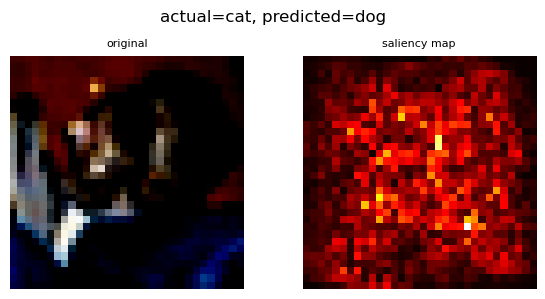

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


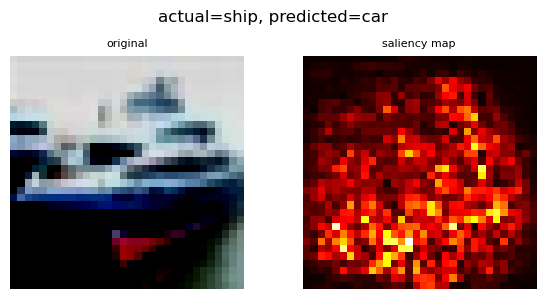

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


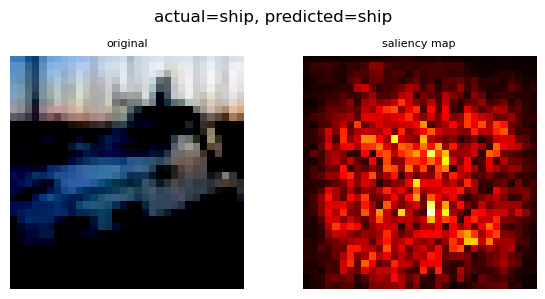

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


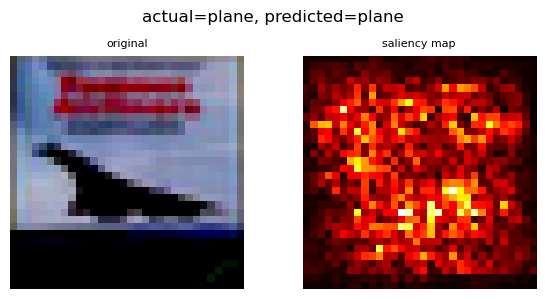

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


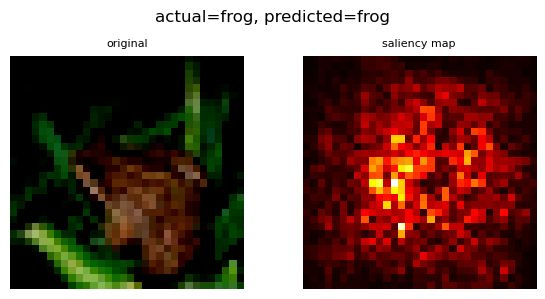

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


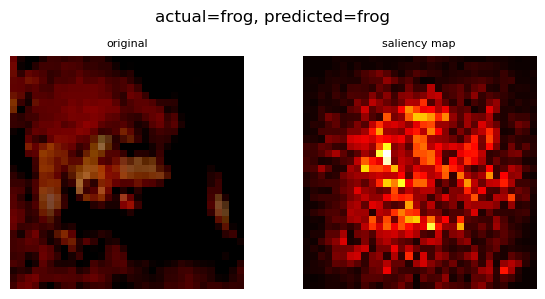

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


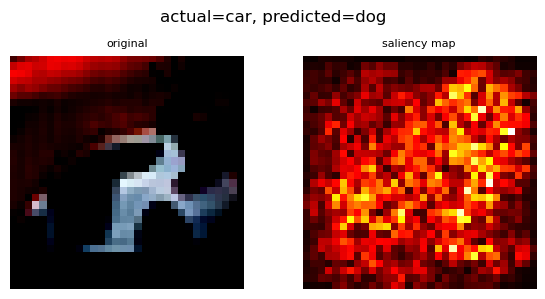

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


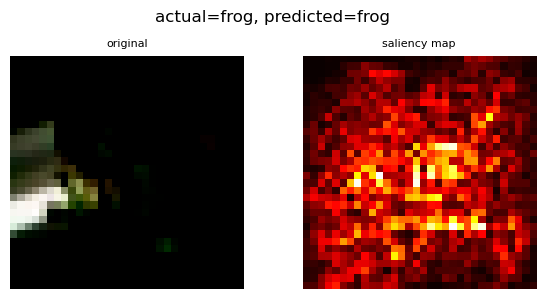

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


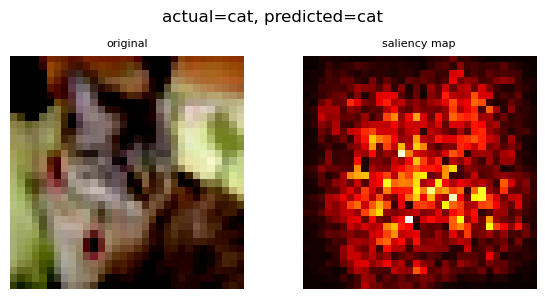

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


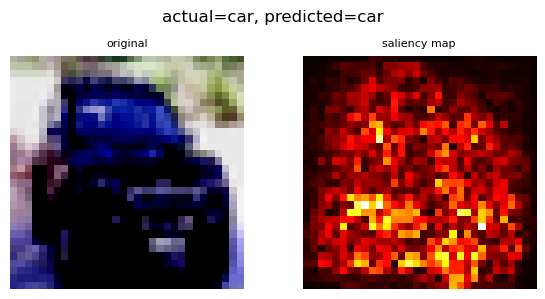

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


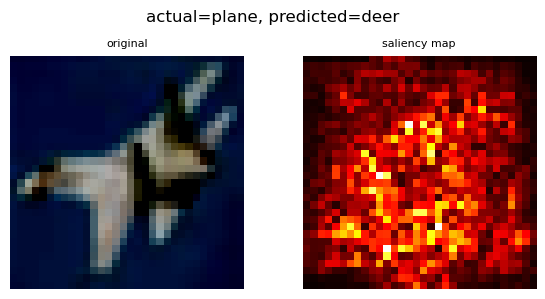

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


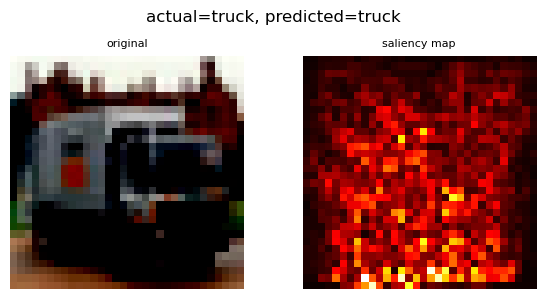

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


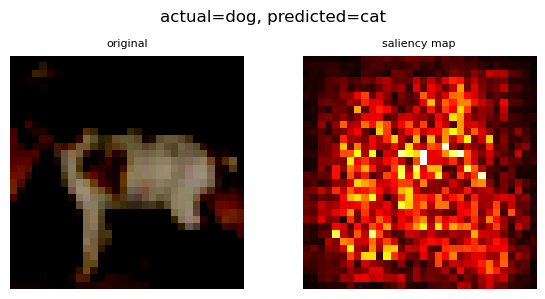

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


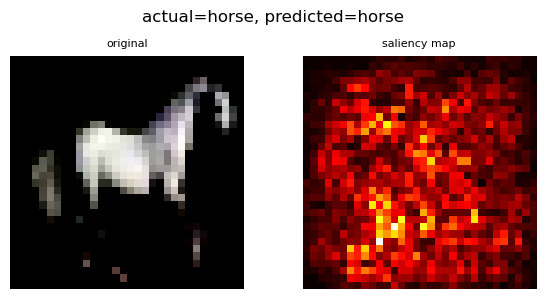

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


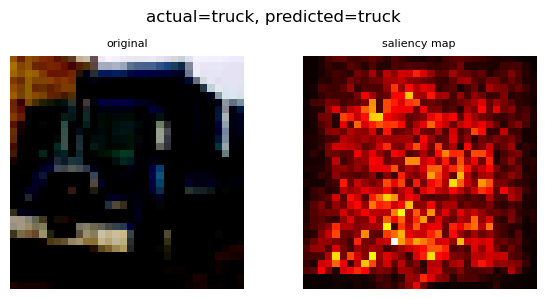

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


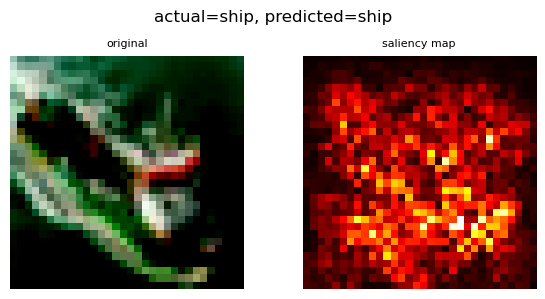

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


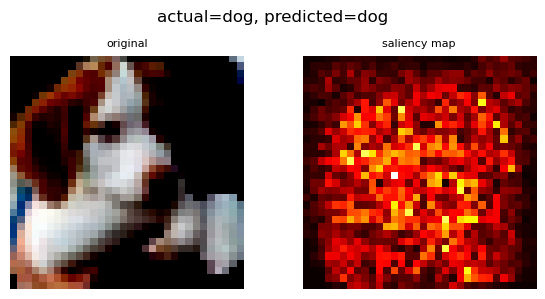

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


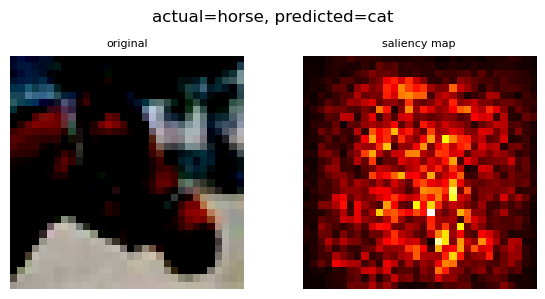

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


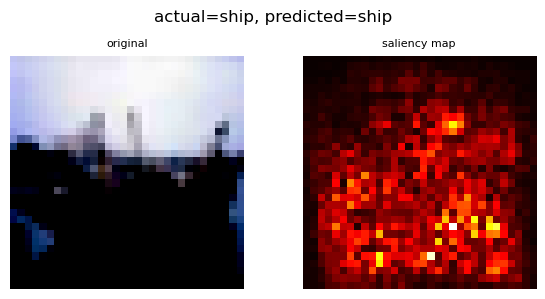

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


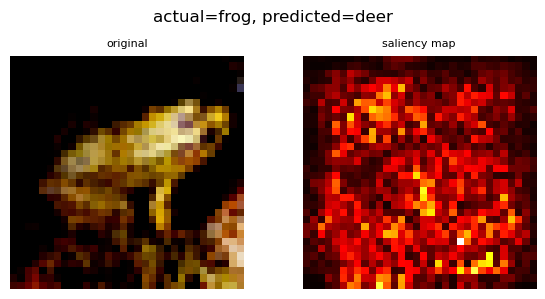

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


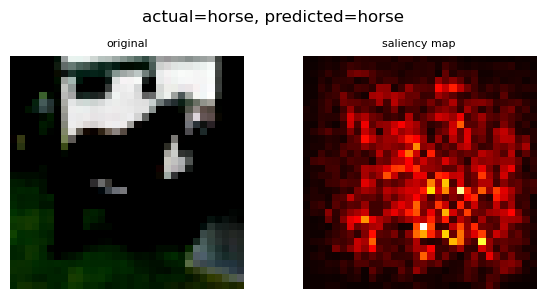

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


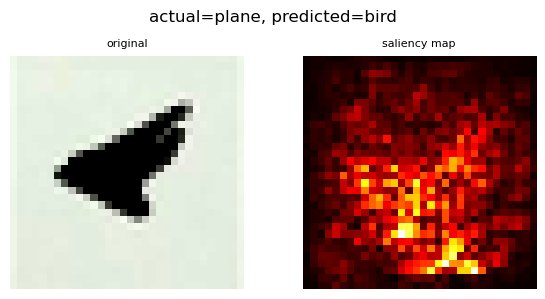

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


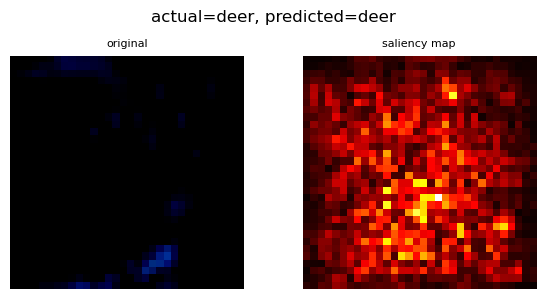

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


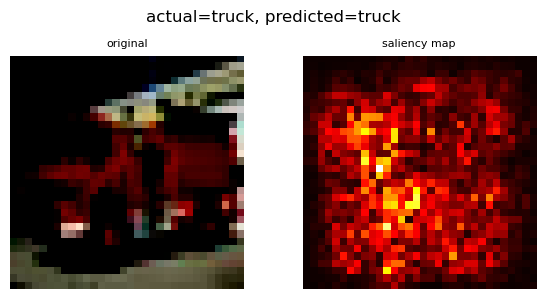

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


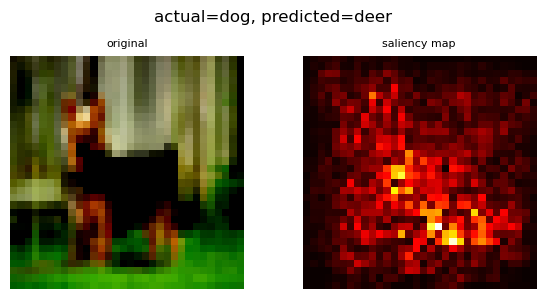

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


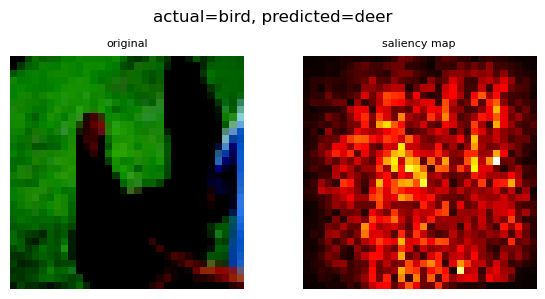

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


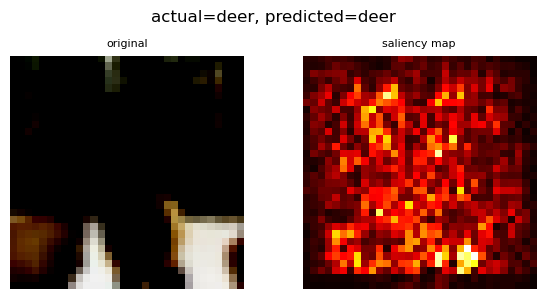

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


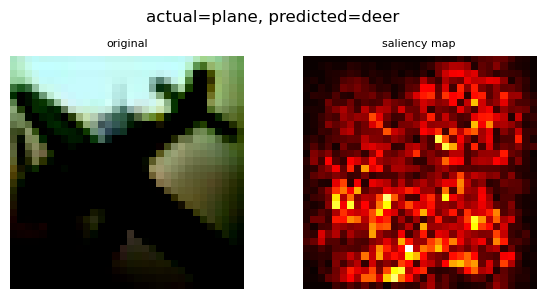

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


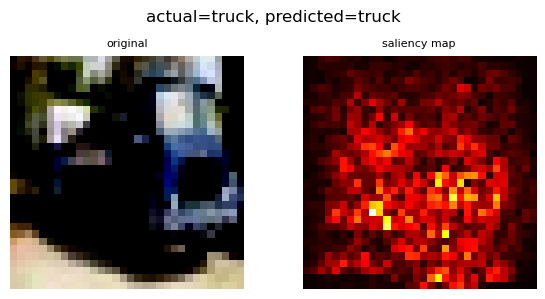

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


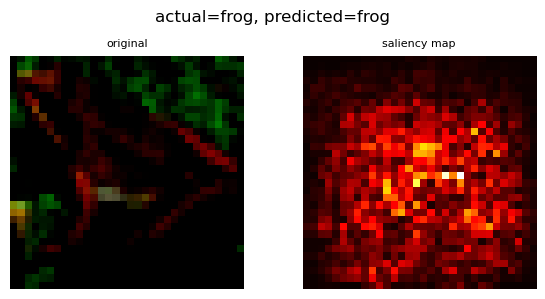

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


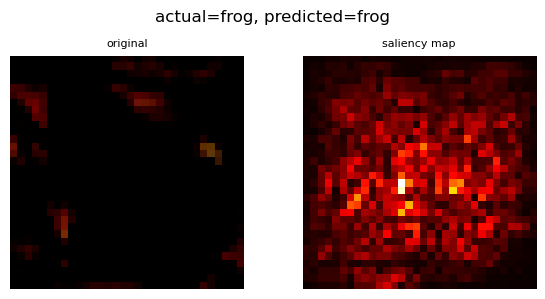

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


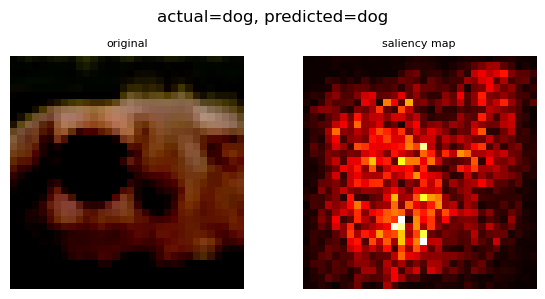

In [75]:

# Get images and labels for first batch of validation set.
images, labels = next(iter(valid_loader))
yactual = labels.detach().numpy()
ypred = mdl(images).argmax(axis=1).detach().numpy()


# For each image in current batch, show original along with saliency map
# with actual and predicted class labels.
for ii in range(len(yactual)):
    tensor = images[[ii]]
    img, saliency = get_saliency(tensor, mdl)
    actual_label, predicted_label = classes[yactual[ii]], classes[ypred[ii]]
    plot_saliency(img, saliency, actual_label, predicted_label)



<br>

We can observe which regions are highlighted in the saliency map for each image, and start to get an idea of which image characteristics result in a particular prediction. This is an informative diagnostic and a valuable technique to use when attempting to explain CNN model output.